In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import pytorch_lightning as pl
import time
import copy

from torchsummary import summary
from torch.utils.data.sampler import SequentialSampler
from PIL import Image
from sklearn.model_selection import train_test_split


In [2]:
# TORCH_DEVICE = 'mps' # there is currently a bug: https://github.com/pytorch/pytorch/issues/78915
TORCH_DEVICE = 'cpu'
CKPT_PATH = '../../Faster_R-CNN_GZ2/pre_trained_models/Zoobot_Resnet_Torchvision/'
CKPT_NAME = 'epoch=20-step=6552.ckpt'

DATA_PATH = '../Data/'
IMAGE_PATH = DATA_PATH + 'real_pngs/'

LOG_DIR = './logs/train'
MODEL_SAVE_PATH = './checkpoints/'

# using typical split of 80:10:10
SIZE_OF_VALIDATION_SET = 0.1
SIZE_OF_TEST_SET = 0.1

BATCH_SIZE = 8

RESIZE_SIZE = 224   # Zoobot, as pretrained, expects 224x224 images
IS_COLOUR = True
CROP_SCALE_BOUNDS = (0.7, 0.8)
CROP_RATIO_BOUNDS = (0.9, 1.1)


In [3]:
# Creating the datasets
df = pd.read_csv(DATA_PATH + 'clumps.csv')
df = df.sample(frac=0.01)

# Randomly divide into train and validation sets using sklearn
# train_df, hidden_df = train_test_split(df, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET)
# val_df, test_df = train_test_split(hidden_df, test_size=SIZE_OF_TEST_SET / (SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET))
train_df, val_df = train_test_split(df, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET, random_state=42)

print('Training subjects: {}'.format(len(train_df)))
print('Val subjects: {}'.format(len(val_df)))
# print('Test subjects: {}'.format(len(test_df)))
# print('Sum: {}, of {} in total.'.format(len(train_df)+len(val_df)+len(test_df), len(df)))
print('Sum: {}, of {} in total.'.format(len(train_df)+len(val_df), len(df)))

Training subjects: 364
Val subjects: 92
Sum: 456, of 456 in total.


In [4]:
df.head()

,zoo_id,id,filename,file_exists,local_ids,empty,dr8objid,ra,dec,fwhm,origin,redshift,fwhmImagePix,arcsecPerSide,fwhmNativePix,label,label_text
22044,36756490,289399624468,289399624468.png,True,289399624468,True,1237658298990330008,142.81012,5.35993,1.325737,real,0.074516,8.331994,63.645607,3.347821,0,w/o clumps
13881,36741951,330348207923,330348207923.png,True,330348207923,False,1237662697040183695,244.62851,20.87924,0.962049,real,0.032344,5.356234,71.845179,2.429417,1,clumpy
19807,36752263,316655913399,316655913399.png,True,316655913399,True,1237658203429208218,156.65586,45.24475,1.190502,real,0.026962,4.761801,100.004356,3.006318,0,w/o clumps
35875,36793731,244970155187,244970155187.png,True,244970155187,False,1237661463840358796,238.56008,32.25225,0.984267,real,0.071209,9.842675,40.000000,2.485524,1,clumpy
38089,36798137,332789832203,332789832203.png,True,332789832203,False,1237668590259404935,183.71419,17.62596,1.009746,real,0.077330,6.073994,66.496342,2.549864,1,clumpy


In [5]:
# Data augmentation and normalization for training
def get_transform(train, is_colour=True):
    augs = []
    
    if train:
        augs.append(transforms.RandomResizedCrop(
            RESIZE_SIZE, 
            scale=CROP_SCALE_BOUNDS,
            ratio=CROP_RATIO_BOUNDS,
            interpolation=transforms.InterpolationMode.BILINEAR)
        )
        augs.append(transforms.RandomHorizontalFlip(0.5))
        augs.append(transforms.RandomRotation(
            degrees=180., 
            interpolation=transforms.InterpolationMode.BILINEAR)
        )
    else:
        augs.append(transforms.Resize(RESIZE_SIZE))
        augs.append(transforms.CenterCrop(RESIZE_SIZE))

    # augs.append(transforms.PILToTensor())
    # augs.append(transforms.ConvertImageDtype(torch.float))
    augs.append(transforms.ToTensor())

    # if is_colour:
    #     augs.append(transforms.Normalize(
    #         [0.485, 0.456, 0.406], 
    #         [0.229, 0.224, 0.225])
    #     )
    
    return transforms.Compose(augs)

In [6]:
# Dataset class and defined transformations
import SDSSGalaxyDataset
image_datasets = {}

image_datasets['train'] = SDSSGalaxyDataset.SDSSGalaxyDatasetClassification(
    dataframe=train_df,
    image_dir=IMAGE_PATH,
    colour=IS_COLOUR,
    transforms=get_transform(train=True, is_colour=True)
)
image_datasets['val'] = SDSSGalaxyDataset.SDSSGalaxyDatasetClassification(
    dataframe=val_df,
    image_dir=IMAGE_PATH,
    colour=IS_COLOUR,
    transforms=get_transform(train=False, is_colour=True)
)

dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
) for x in ['train', 'val']}

print("Count: {} are training and {} validation".format(len(image_datasets['train']), len(image_datasets['val'])))

Count: 364 are training and 92 validation


In [24]:
images, labels = next(iter(dataloaders_dict['train']))
images = list(image.to(TORCH_DEVICE) for image in images)
labels = list(label.to(TORCH_DEVICE) for label in labels)

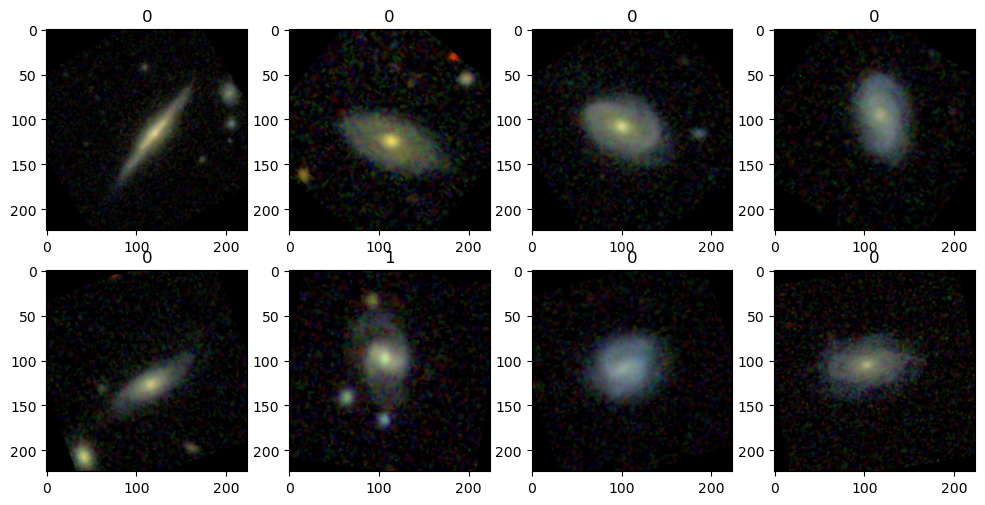

In [25]:
plt.figure(figsize=(12, 12))
for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title(labels[i].cpu().numpy().astype(np.int32))

In [53]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def create_model(feature_extract=False):
    # Get Zoobot model and weights - Resnet
    import define_model
    zoobot = define_model.ZoobotLightningModule(
        output_dim=34,
        question_index_groups=['idx1', 'idx2'],
        include_top=True,
        channels=3,
        use_imagenet_weights=False,
        always_augment=True,
        dropout_rate=0.2,
        architecture_name='resnet_torchvision'
    )
    checkpoint = torch.load(CKPT_PATH+CKPT_NAME, map_location=torch.device(TORCH_DEVICE))
    zoobot.load_state_dict(checkpoint['state_dict'])

    # select layers for feature map
    model = zoobot.model[0][0:10]
    set_parameter_requires_grad(model, feature_extract)
    
    model.classifier = nn.Sequential(
        nn.BatchNorm1d(2048),
        nn.Dropout(p=0.25),
        nn.Linear(in_features=2048, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=1),
        nn.ReLU(),
        # nn.Sigmoid()
    )

    return model

In [54]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(TORCH_DEVICE)
                labels = labels.to(TORCH_DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.unsqueeze(1))

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # plot_grad_flow(model.named_parameters())
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('Running corrects: {} No. of samples: {}'.format(running_corrects, len(dataloaders[phase].dataset)))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [56]:
# get the model
zoobot_clumps = create_model(feature_extract=True)

# move model to the right device
zoobot_clumps = zoobot_clumps.to(TORCH_DEVICE)

# Gather the parameters to be optimized/updated in this run. 
params_to_update = zoobot_clumps.parameters()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(params_to_update, lr=0.0001, weight_decay=0.0005)

# Setup the loss fxn
criterion = nn.BCEWithLogitsLoss()

# Train and evaluate
model_ft, hist = train_model(
    zoobot_clumps, 
    dataloaders_dict, 
    criterion, 
    optimizer, 
    num_epochs=10
)

Epoch 0/9
----------
train Loss: 0.7011 Acc: 0.5549
Running corrects: 202 No. of samples: 364
val Loss: 0.6820 Acc: 0.4783
Running corrects: 44 No. of samples: 92

Epoch 1/9
----------
train Loss: 0.6805 Acc: 0.5549
Running corrects: 202 No. of samples: 364
val Loss: 0.6674 Acc: 0.4783
Running corrects: 44 No. of samples: 92

Epoch 2/9
----------
train Loss: 0.6724 Acc: 0.5549
Running corrects: 202 No. of samples: 364
val Loss: 0.6705 Acc: 0.4783
Running corrects: 44 No. of samples: 92

Epoch 3/9
----------
train Loss: 0.6626 Acc: 0.5549
Running corrects: 202 No. of samples: 364
val Loss: 0.6770 Acc: 0.4783
Running corrects: 44 No. of samples: 92

Epoch 4/9
----------
train Loss: 0.6740 Acc: 0.5549
Running corrects: 202 No. of samples: 364
val Loss: 0.6716 Acc: 0.4783
Running corrects: 44 No. of samples: 92

Epoch 5/9
----------
train Loss: 0.6738 Acc: 0.5549
Running corrects: 202 No. of samples: 364
val Loss: 0.6824 Acc: 0.4783
Running corrects: 44 No. of samples: 92

Epoch 6/9
------

In [190]:
from torchsummary import summary
summary(zoobot_clumps, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [45]:
model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(model.fc.in_features, 1)
for param in model.parameters():
    param.requires_grad = True

In [40]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 